# Simple Advection example

The advection equation

$$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 $$

is one of the simplest partial differential equation. It describes a hyperbolic
transport process. Under periodic boundary conditions, the solution at a point
later in time is given by the moved initial condition

$$ u(x, t) = u_0((x - c t) \mod L) $$

using some loose notation of the modulo operator to enfore periodicity.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import exponax as ex

Let's first create a grid that discretizes the domain $[0, L]$ into $N$ degrees
of freedom. Since we work with **periodic domains**, one of the boundary points,
either $x=0$ or $x=L$, is redundant. Hence, we will linearly space $N+1$ points
over the domain and discard the last one. (Actually, discarding one boundary
point is a prerequisite for using the FFT algorithm that is baked in all the
solvers that are part of `Exponax`.)

2024-03-01 14:57:24.421211: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


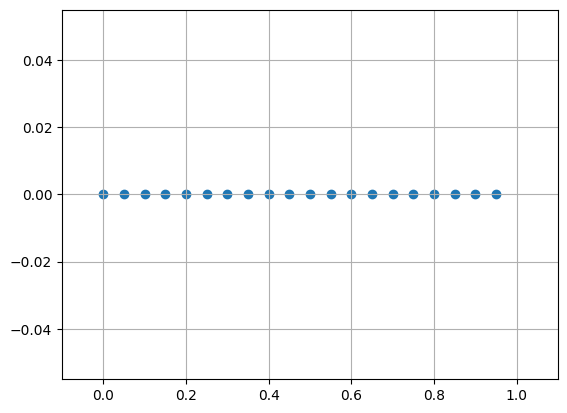

In [3]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 20
grid = jnp.linspace(0, DOMAIN_EXTENT, NUM_POINTS + 1)[:-1]

plt.scatter(grid, jnp.zeros_like(grid))
plt.xlim(-0.1, 1.1)
plt.grid()

We can also print out the `jax.numpy` array containing the grid

In [4]:
grid

Array([0.        , 0.05      , 0.1       , 0.15      , 0.2       ,
       0.25      , 0.3       , 0.35      , 0.4       , 0.45000002,
       0.5       , 0.55      , 0.6       , 0.65000004, 0.7       ,
       0.75      , 0.8       , 0.85      , 0.90000004, 0.95      ],      dtype=float32)

Handily, there is a function in `Exponax` that produces a grid

In [5]:
grid_from_exponax = ex.make_grid(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
)
grid_from_exponax

Array([[0.        , 0.05      , 0.1       , 0.15      , 0.2       ,
        0.25      , 0.3       , 0.35      , 0.4       , 0.45000002,
        0.5       , 0.55      , 0.6       , 0.65000004, 0.7       ,
        0.75      , 0.8       , 0.85      , 0.90000004, 0.95      ]],      dtype=float32)

This function takes three positional arguments:

1. `num_spatial_dims` defining the dimensionality of the domain. For this
   tutorial, we work in 1D, so we pass `1`.
2. `domain_extent`
3. `num_points`

Note that the shape of the grid array is different from the shape we got from `jax.numpy.linspace`.

In [6]:
grid.shape, grid_from_exponax.shape

((20,), (1, 20))

It has an additional *singleton dimension* in the beginning. This is to
represent the dimensionality of the grid. In 1D, the shape of the grid is `(1,
N)`. In 2D, it would be `(2, N, N)`, and so on.

**Let's work with the `grid_from_eponax` from now on.**

In [7]:
grid = grid_from_exponax

On this domain, we can discretize a function. Let's, for instance, use the first
sine mode $u_0(x) = \sin(2 \pi x / L)$.

Notice that we have to index both the grid array and the function array at `[0]`
to remove the singleton dimension, and get an array for plotting.

Notice that we do not have a function value at $x=1$ since we discarded the
last mesh point.

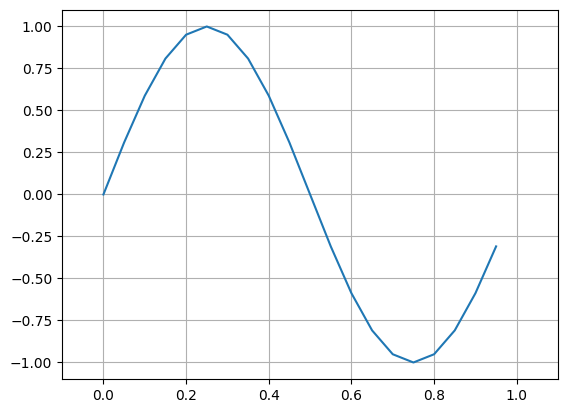

In [8]:
ic_fun = lambda x: jnp.sin(2 * jnp.pi * x / DOMAIN_EXTENT)
ic = ic_fun(grid)

plt.plot(grid[0], ic[0])
plt.xlim(-0.1, 1.1)
plt.grid()

If we wanted to plot the function including its periodic extension, we had to
wrap around the domain. This can be done by the `wrap_bc` function. Note that in
order to then plot the function, we also need the "full grid" including the
redundant point.

Notice again that we index at `[0]` to remove the singleton dimension.

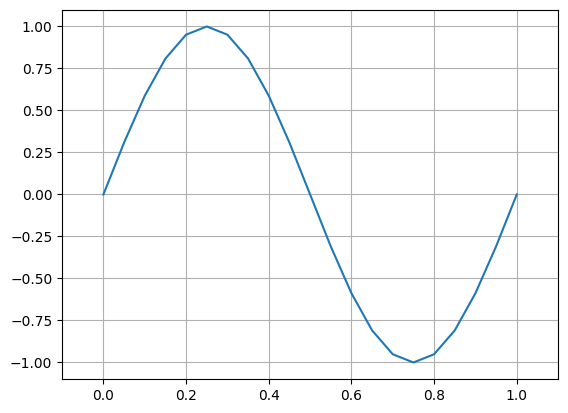

In [9]:
full_grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS, full=True)
full_ic = ex.wrap_bc(ic)
plt.plot(full_grid[0], full_ic[0])
plt.xlim(-0.1, 1.1)
plt.grid()

Next, let's instantiate the advection timestepper. We need to specify the
velocity $c$ and the timestep $\Delta t$.

Note that (almost) all timesteppers in *Exponax* take as first four positional arguments:

1. The `num_spatial_dims` defining the dimensionality of the domain. For this
   tutorial, we work in 1D, so we pass `1`.
1. The `domain_extent`
2. The `num_points` (Important: Exclude the redundant point!)
3. The timestep `dt`

**in this order**.

Other options, such as coefficients/constitutional parameters or numerical
parameters, are passed as keyword arguments.

An advection problem is defined by its external velocity which we assume to be a constant $c=1.0$.

In [10]:
VELOCITY = 1.0
DT = 0.2

advection_stepper = ex.stepper.Advection(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    velocity=VELOCITY,
)

advection_stepper

Advection(
  num_spatial_dims=1,
  domain_extent=1.0,
  num_points=20,
  num_channels=1,
  dt=0.2,
  dx=0.05,
  _integrator=ETDRK0(dt=0.2, _exp_term=c64[1,11]),
  velocity=f32[1]
)

Once instantiated, the timesteppers behave like a Python callable, taking a
discretized function at time $t$ (now called a **state**) and returning the
discretized function at time $t + \Delta t$ (i.e., the **next state**).

In [11]:
u_1 = advection_stepper(ic)

Let's plot the solution at $t=0$ and $t=0.1$ next to each other.

(Again, notice the indexing at `[0]` to remove the singleton dimension.)

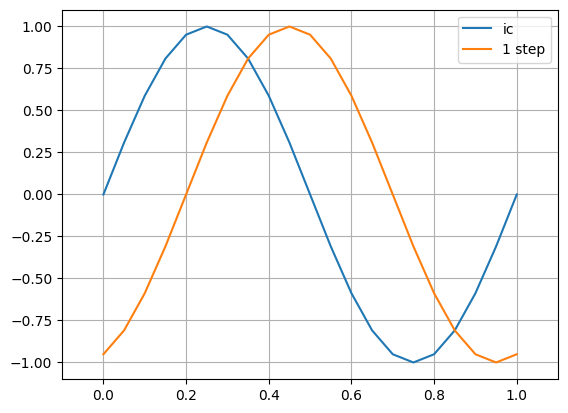

In [12]:
plt.plot(full_grid[0], ex.wrap_bc(ic)[0], label="ic")
plt.plot(full_grid[0], ex.wrap_bc(u_1)[0], label="1 step")
plt.xlim(-0.1, 1.1)
plt.grid()
plt.legend()

You notice that the initial condition moved by $0.2$ space units to the right.
Additionally, whatever left the domain at the right boundary re-entered at the
left boundary. The shape of the function is preserved!

Moving by $0.2$ space units in $0.2$ time units corresponds to a velocity of $c
= 1$ which is exactly what we prescribed. Feel free to play around with the
velocity $c$, the timestep $\Delta t$, and the domain size $L$ to see how the
solution changes. You will notice that ultimately only the value $\frac{c \Delta
t}{L}$ matters.


For any time-dependent phenomenon, we might be interested in not just computing
one timestep into the future, but many. This is an inherently sequential process
because we need the solution at time $t$ to compute the solution at time $t +
\Delta t$. Let's compute the three following solutions.

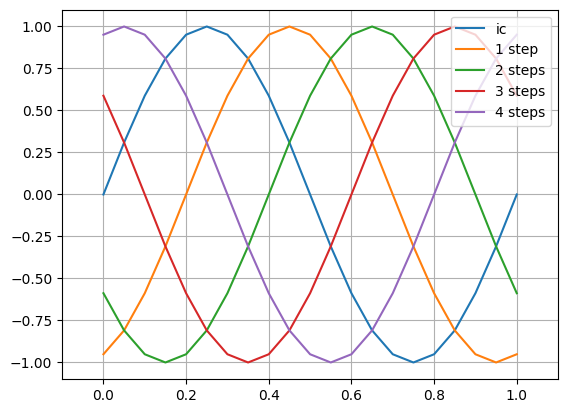

In [13]:
u_2 = advection_stepper(u_1)
u_3 = advection_stepper(u_2)
u_4 = advection_stepper(u_3)

plt.plot(full_grid[0], ex.wrap_bc(ic)[0], label="ic")
plt.plot(full_grid[0], ex.wrap_bc(u_1)[0], label="1 step")
plt.plot(full_grid[0], ex.wrap_bc(u_2)[0], label="2 steps")
plt.plot(full_grid[0], ex.wrap_bc(u_3)[0], label="3 steps")
plt.plot(full_grid[0], ex.wrap_bc(u_4)[0], label="4 steps")
plt.xlim(-0.1, 1.1)
plt.grid()
plt.legend()

If we had performed another timestep, we would have returned to the initial
condition because doing $5$ steps with a $c \cdot \Delta t = 0.2$ velocity
corresponds to moving by $1$ space unit. This is exactly the length of the
domain $L$!

Now, we are interested in **stacking the time steps into a trajectory**.
Manually, we could do this the following way.

In [14]:
short_trajectory = jnp.stack(
    [
        ic,
        u_1,
        u_2,
        u_3,
        u_4,
    ]
)
short_trajectory.shape

(5, 1, 20)

There is also a handy function within `Exponax` that does exactly this. In the
spirit of `JAX` it is a function transformation. So far the `advection_stepper`
is a mapping of $\R^{1 \times N} \mapsto \R^{1 \times N}$. This function
transformation turns it into a mapping of $\R^{1 \times N} \mapsto \R^{T \times
1 \times N}$ where $T$ is the number of time steps we want to perform into the
future. It has the additional keyword flag to include the initial condition in
the trajectory. Then, we mapping is $\R^{N+1} \mapsto \R^{(T+1) \times 1 \times N}$.

In [15]:
short_rollout_advection_stepper = ex.rollout(advection_stepper, 4, include_init=True)
jnp.allclose(short_trajectory, short_rollout_advection_stepper(ic))

Array(True, dtype=bool)

Let's instantiate another advection timestepper with a smaller timestep and roll it out for $200$ steps
Let's use the `rollout` transformation for a longer trajectory, say $200$ steps.

In [16]:
SMALLER_DT = 0.01
slower_advection_stepper = ex.stepper.Advection(
    1, DOMAIN_EXTENT, NUM_POINTS, SMALLER_DT, velocity=VELOCITY
)
longer_rollout_advection_stepper = ex.rollout(
    slower_advection_stepper, 200, include_init=True
)
longer_trajectory = longer_rollout_advection_stepper(ic)

Then we can `jax.vmap` the `wrap_bc` function over the trajectory.

In [17]:
longer_trajectory_wrapped = jax.vmap(ex.wrap_bc)(longer_trajectory)

Then, we can visualize the trajectory as a spatio-temporal plot.

The indexing `[:, 0, :]` takes all temporal shapshots, removes the singleton
domension, and takes all spatial points. We use a transposition `.T` to have the
time dimension on the horizontal axis.

Text(0.5, 1.0, 'advection')

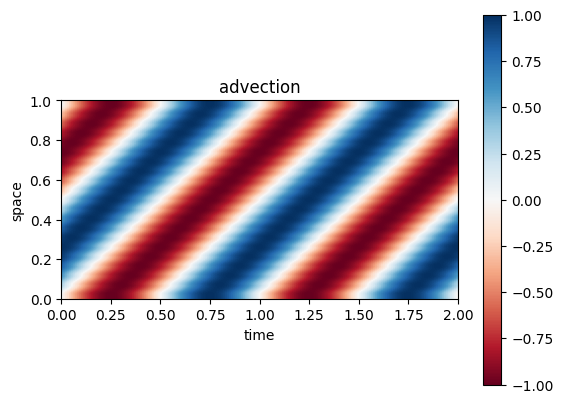

In [18]:
plt.imshow(
    longer_trajectory_wrapped[:, 0, :].T,
    origin="lower",
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    extent=[0, 200 * SMALLER_DT, 0, DOMAIN_EXTENT],
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")
plt.title("advection")